# Projeto de Recomendações de músicas com o spotipy

**Objetivo:** Construir um sistema de recomendação de músicas com a API do Spotify utilizando o Spark

## Importação das bibliocas e bases de dados

In [1]:
!pip install pyspark;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=04f88a2f2a7022afe3b994ab8fe5839b5ce45249587437f5331e188ad53c51da
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
sessao_spark = SparkSession.builder
import pandas as pd
import pyspark.sql.functions as f

sessao_spark = SparkSession.builder\
                           .appName("Recomendador PySpark")\
                           .getOrCreate()
sessao_spark


In [3]:
#Bibioteca para baixar dados de pastas externas como o GitHub
from pyspark import SparkFiles

In [4]:
#Acessando base de dados de músicas do github
url_dados = 'https://github.com/IgorNascAlves/dados/blob/main/dados_musicas.csv?raw=true'
sessao_spark.sparkContext.addFile(url_dados)
path_dados_file = 'file://' + SparkFiles.get('dados_musicas.csv')

dados = sessao_spark.read.csv(path_dados_file, header=True, sep=';', inferSchema=True)
dados.show()

+------------------+----+------------+--------------+------------------+-----------+------------------+--------+--------------------+--------------------+---+--------+-------------------+----+--------------------+----------+-----------+------------------+--------------------+
|           valence|year|acousticness|       artists|      danceability|duration_ms|            energy|explicit|                  id|    instrumentalness|key|liveness|           loudness|mode|                name|popularity|speechiness|             tempo|        artists_song|
+------------------+----+------------+--------------+------------------+-----------+------------------+--------+--------------------+--------------------+---+--------+-------------------+----+--------------------+----------+-----------+------------------+--------------------+
|             0.285|2000|     0.00239|      Coldplay|             0.429|     266773|0.6609999999999999|       0|3AJwUDP919kvQ9Qco...|             1.21E-4| 11|   0.234|  

In [5]:
#Acessando base de dados de gêneros musicais do github
url_dados = 'https://github.com/IgorNascAlves/dados/blob/main/dados_musicas_genero.csv?raw=true'
sessao_spark.sparkContext.addFile(url_dados)
path_dados_file = 'file://' + SparkFiles.get('dados_musicas_genero.csv')

dados_generos = sessao_spark.read.csv(path_dados_file, header=True, sep=',', inferSchema=True)
dados_generos.show()

+----+--------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+---+
|mode|              genres|       acousticness|       danceability|       duration_ms|             energy|    instrumentalness|           liveness|           loudness|         speechiness|             tempo|            valence|        popularity|key|
+----+--------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+---+
|   1|21st century clas...| 0.9793333333333332|0.16288333333333335|160297.66666666663|0.07131666666666665|          0.60683367|             0.3616|-31.514333333333337| 0.04056666666666667|           75.3365|0.10378333333333334| 27.83333333333333| 

## Aplicação das bibliotecas de pré-processamento para o sistema de recomendação

In [29]:
#Bibliotecas utilizadas para o pré-processamento
from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans

In [30]:
#Excluindo as colunas que não vou utilizar
X = dados.columns
X.remove('artists')
X.remove('id')
X.remove('name')
X.remove('artists_song')

#Aplicando a vetorização e a normalização das features que serão utilizadas
dados_encoded_vector = VectorAssembler(inputCols=X, outputCol='features').transform(dados)
scaler = StandardScaler(inputCol='features', outputCol='features_scaled')
model_scaler = scaler.fit(dados_encoded_vector)
dados_musicas_scaler = model_scaler.transform(dados_encoded_vector)
k = len(X)

In [ ]:
#Aplicação do modelo de redução de dimensionalidade para melhorar a explicação das recomendações
pca = PCA(k=k, inputCol='features_scaled', outputCol='pca_features')
model_pca = pca.fit(dados_musicas_scaler)
dados_musicas_pca = model_pca.transform(dados_musicas_scaler)


In [10]:
#Listando o grau de explicação par entender qual é o melhor número de cluster a ser utilizado
lista_valores = [sum(model_pca.explainedVariance[0:i+1]) for i in range(k)]
lista_valores

[0.21297354127107349,
 0.3459774162295507,
 0.43989805678254446,
 0.5267820578269103,
 0.6001038103117929,
 0.666571951365239,
 0.7282174213581728,
 0.7845103843321023,
 0.8350002357002614,
 0.8812446547406769,
 0.9151737562703048,
 0.9435370133056039,
 0.9699018569070161,
 0.9900947792885582,
 1.0000000000000002]

In [32]:
import numpy as np

#Aplicando o grau de explicação em 70% do modelo
k = sum(np.array(lista_valores) <= 0.7)
k

6

In [33]:
#Para o grau de explicação de 70% encontramos que 6 clusters serão utilizados para o algoritmo de recomendação
pca = PCA(k=6, inputCol='features_scaled', outputCol='pca_features')
model_pca = pca.fit(dados_musicas_scaler)
dados_musicas_pca_final = model_pca.transform(dados_musicas_scaler)
dados_musicas_pca_final.select('pca_features').show(truncate=False, n=5)

+----------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------+
|[-34.71004464775702,-165.3684878490617,-11.163498729833675,-139.1137428085442,14.152192300931317,-6.254422223810444]  |
|[-36.49885762774904,-167.85185045616547,-10.729023248907904,-135.90435265671286,13.38840189058717,-3.972980727830917] |
|[-35.46030091694054,-165.99633344577876,-11.361290348241944,-138.24276881246985,13.866654919305718,-4.342675920458773]|
|[-35.56301325520582,-165.59515096480598,-11.46022600703173,-137.52095740570027,15.568542803922659,-4.542073725584329] |
|[-36.54556974907565,-167.37512505802474,-11.881276527236897,-136.27798590243967,14.056847990344485,-3.583390145779214]|
+-------------------------------

### Aplicação do cluster com K-Means

In [34]:
#Após separmos as músicas em clusters vamos encontrar os vizinhos mais próximos através do KMeans, assim encontraremos quais músicas são semelhantes à música selecionada
pca_pipeline = Pipeline(stages=[VectorAssembler(inputCols=X, outputCol='features'),
                                StandardScaler(inputCol='features', outputCol='features_scaled'),
                                PCA(k=6, inputCol='features_scaled', outputCol='pca_features')])

model_pca_pipeline = pca_pipeline.fit(dados)
projection = model_pca_pipeline.transform(dados)

In [35]:
kmeans = KMeans(k=50, featuresCol='pca_features', predictionCol='cluster_pca')
modelo_kmeans = kmeans.fit(projection)
projetion_kmeans = modelo_kmeans.transform(projection)

## Sistemas de Recomendação

In [43]:
from scipy.spatial.distance import euclidean
from pyspark.sql.types import FloatType

In [46]:
#Para facilitar a aplicação do modelo foi criada uma função que recebe o nome da música e retorna as recomendações
#Lembrando que o sistema é baseado na distência euclidiana dos vizinhos mais próximos para encontrar as recomendações
def recomendador(nome_musica):
  cluster = projetion_kmeans.filter(projetion_kmeans.artists_song == nome_musica).select('cluster_pca').collect()[0][0]
  musicas_recomendadas = projetion_kmeans.filter(projetion_kmeans.cluster_pca == cluster)\
                                       .select('artists_song', 'id', 'pca_features')
  componenetes_musica = musicas_recomendadas.filter(musicas_recomendadas.artists_song == nome_musica)\
                                          .select('pca_features').collect()[0][0]



  def calcula_distance(value):
    return euclidean(componenetes_musica, value)

  udf_calcula_distance = f.udf(calcula_distance, FloatType())

  musicas_recomendadas_dist = musicas_recomendadas.withColumn('Dist', udf_calcula_distance('pca_features'))

  recomendadas = sessao_spark.createDataFrame(musicas_recomendadas_dist.sort('Dist').take(10)).select(['artists_song', 'id', 'Dist'])

  recomendadas.select('artists_song').show(truncate=False)

In [48]:
recomendador('Coldplay - Yellow')

+---------------------------------------------------------+
|artists_song                                             |
+---------------------------------------------------------+
|Coldplay - Yellow                                        |
|All Time Low - Remembering Sunday                        |
|All Time Low - Therapy                                   |
|Mat Kearney - Ships In The Night                         |
|Imagine Dragons - Bleeding Out                           |
|Cole Swindell - Hope You Get Lonely Tonight              |
|Miley Cyrus - Every Rose Has Its Thorn                   |
|Three Days Grace - Human Race                            |
|Tame Impala - Feels Like We Only Go Backwards            |
|Jason Aldean - Don't You Wanna Stay (with Kelly Clarkson)|
+---------------------------------------------------------+



##Melhorando o modelo: Trazendo informações da API do Spotify

In [49]:
#Baixando as bibliotecas de acesso e autenticação
!pip install spotipy;
import spotipy
from spotipy.oauth2 import SpotifyOAuth, SpotifyClientCredentials


In [50]:
#Estabalecendo as credenciais de acesso
scope = "user-library-read playlist-modify-private"

OAuth = SpotifyOAuth(
        scope=scope,
        redirect_uri='http://localhost:5000/callback',
        client_id = '7a7c9cd9ecb34593856880c4af3a46ba',
        client_secret = '591c0c6aba4243dd9804c20a605164ef')

client_credentials_manager = SpotifyClientCredentials(client_id = '7a7c9cd9ecb34593856880c4af3a46ba',
                                                      client_secret = '591c0c6aba4243dd9804c20a605164ef')

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [52]:
#Importando as bibliotecas de visualização d imagens
import matplotlib.pyplot as plt
from skimage import io

In [53]:

def recomendador(nome_musica):
 #Calcula musicas recomendadas
  cluster = projetion_kmeans.filter(projetion_kmeans.artists_song == nome_musica).select('cluster_pca').collect()[0][0]
  musicas_recomendadas = projetion_kmeans.filter(projetion_kmeans.cluster_pca == cluster)\
                                       .select('artists_song', 'id', 'pca_features')
  componenetes_musica = musicas_recomendadas.filter(musicas_recomendadas.artists_song == nome_musica)\
                                          .select('pca_features').collect()[0][0]

  def calcula_distance(value):
    return euclidean(componenetes_musica, value)

  udf_calcula_distance = f.udf(calcula_distance, FloatType())

  musicas_recomendadas_dist = musicas_recomendadas.withColumn('Dist', udf_calcula_distance('pca_features'))

  recomendadas = sessao_spark.createDataFrame(musicas_recomendadas_dist.sort('Dist').take(10)).select(['artists_song', 'id', 'Dist'])

  #Pegar informações da API

  playlist_id = recomendadas.select('id').collect()

  name = []
  url = []
  for i in playlist_id:
      track = sp.track(i[0])
      url.append(track["album"]["images"][1]["url"])
      name.append(track["name"])

  #Plotando capas

  plt.figure(figsize=(15,10))
  columns = 5
  for i, u in enumerate(url):
      ax = plt.subplot(len(url) // columns + 1, columns, i + 1)
      image = io.imread(u)
      plt.imshow(image)
      ax.get_yaxis().set_visible(False)
      plt.xticks(color = 'w', fontsize = 0.1)
      plt.yticks(color = 'w', fontsize = 0.1)
      plt.xlabel(name[i], fontsize = 10)
      plt.tight_layout(h_pad=0.7, w_pad=0)
      plt.subplots_adjust(wspace=None, hspace=None)
      plt.grid(visible=None)
  plt.show()


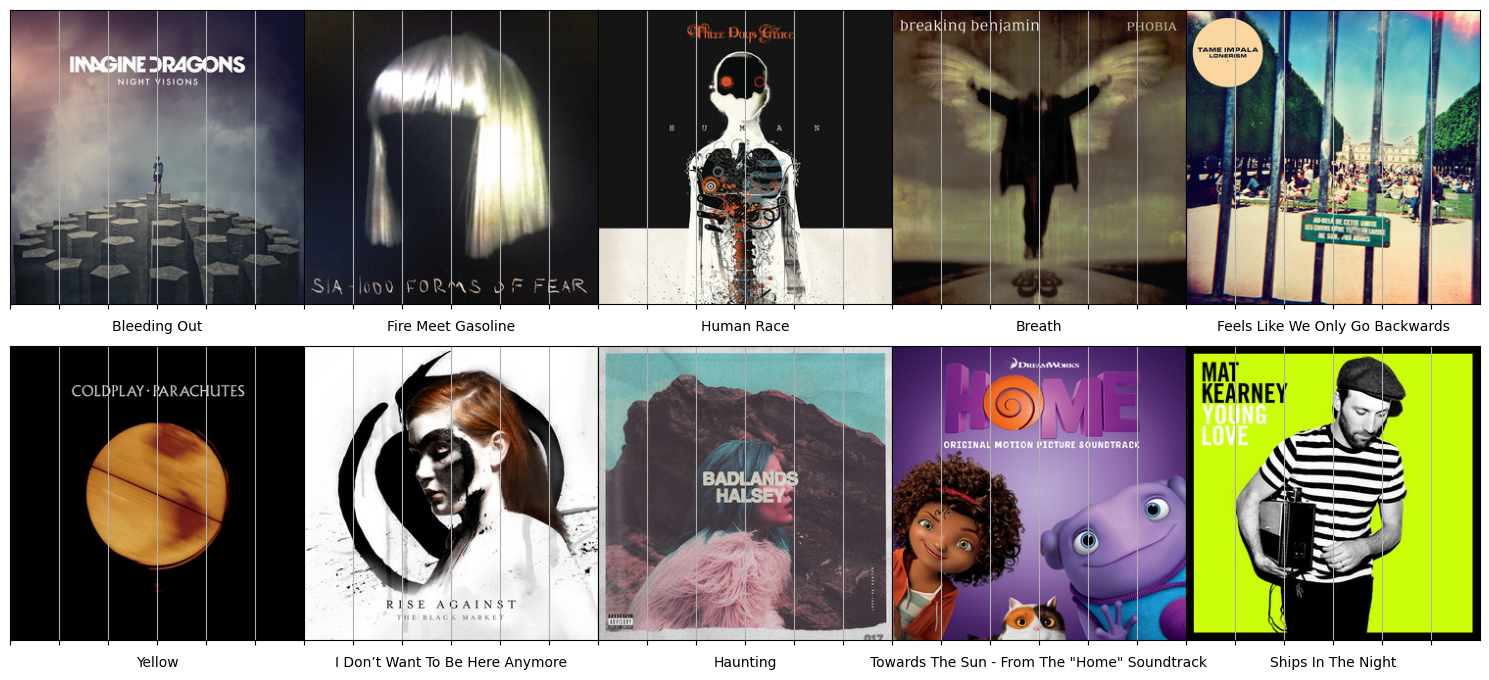

In [56]:
#Aplicando o sistema de recomendação
recomendador('Imagine Dragons - Bleeding Out')